In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, resample
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm

In [2]:
def load_signals_from_mat(folder_path):
    all_signals = []
    skipped_files = []

    mat_files = [f for f in os.listdir(folder_path) if f.endswith('.mat')]

    for filename in tqdm(mat_files, desc="Loading .mat files"):
        try:
            mat = scipy.io.loadmat(os.path.join(folder_path, filename))
            p = mat['p']  # cell array of matrices
            for record in p[0]:  # each cell is one record
                signals = record  # shape: (3, N)
                all_signals.append(signals)
        except Exception as e:
            print(f"Skipping file '{filename}' due to error: {e}")
            skipped_files.append(filename)

    print(f"Loaded {len(all_signals)} records.")
    if skipped_files:
        print(f"Skipped {len(skipped_files)} corrupt or unreadable files.")
    return all_signals

folder_path = "Samples"
signals_list = load_signals_from_mat(folder_path)

Loading .mat files: 100%|██████████████████████████████████████████████████████████████| 12/12 [03:01<00:00, 15.10s/it]

Loaded 12000 records.


In [3]:
def bandpass_filter(signal, lowcut=0.5, highcut=8.0, fs=125, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)

def segment_signal(signal, window_size=125*10):  # 10-second windows
    segments = []
    for start in range(0, len(signal) - window_size, window_size):
        segments.append(signal[start:start + window_size])
    return segments

print("Signal preprocessing functions ready.")

Signal preprocessing functions ready.


In [4]:
def extract_features(ppg, abp, ecg):
    return {
        'ppg_mean': np.mean(ppg),
        'ppg_std': np.std(ppg),
        'ppg_range': np.max(ppg) - np.min(ppg),
        'abp_mean': np.mean(abp),
        'abp_std': np.std(abp),
        'abp_range': np.max(abp) - np.min(abp),
        'ecg_mean': np.mean(ecg),
        'ecg_std': np.std(ecg)
    }

In [5]:
def build_dataset(signals_list):
    data = []
    labels = []
    for signals in signals_list:
        ppg, abp, ecg = signals
        ppg = bandpass_filter(ppg)
        abp = bandpass_filter(abp)
        ecg = bandpass_filter(ecg)

        ppg_segments = segment_signal(ppg)
        abp_segments = segment_signal(abp)
        ecg_segments = segment_signal(ecg)

        for i in range(len(ppg_segments)):
            features = extract_features(ppg_segments[i], abp_segments[i], ecg_segments[i])
            sbp = np.max(abp_segments[i])  # SBP label
            data.append(features)
            labels.append(sbp)

    df = pd.DataFrame(data)
    df['SBP'] = labels
    print(f"Dataset built with {len(df)} samples.")
    return df

df = build_dataset(signals_list)
df.head()

Dataset built with 259740 samples.


,ppg_mean,ppg_std,ppg_range,abp_mean,abp_std,abp_range,ecg_mean,ecg_std,SBP
0,-0.012196,0.604193,2.009114,0.920596,19.154120,84.210697,0.007609,0.169699,59.503382
1,0.012253,0.615889,2.049576,-0.321481,18.388052,60.700357,-0.002816,0.169033,37.680139
2,-0.007629,0.622140,2.038537,0.183480,18.878963,64.652779,0.003727,0.166724,40.314364
3,0.009564,0.631073,2.630415,-0.188351,19.263823,65.108800,-0.001276,0.167280,40.238184
4,-0.007052,0.608034,3.148512,0.326186,19.548355,63.765446,-0.002155,0.164122,39.762335


Dropped 56 rows with missing values.
Model trained.
R² Score: 0.9638552945626504
MAE: 2.0423070859253736


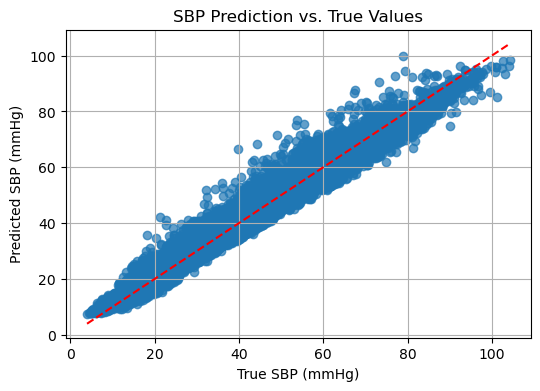

In [6]:
def train_model(df):
    df_clean = df.dropna()
    print(f"Dropped {len(df) - len(df_clean)} rows with missing values.")
    X = df_clean.drop(columns='SBP')
    y = df_clean['SBP']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Model trained.")
    print("R² Score:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))

    # Optional: Plot predictions
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel("True SBP (mmHg)")
    plt.ylabel("Predicted SBP (mmHg)")
    plt.title("SBP Prediction vs. True Values")
    plt.grid(True)
    plt.show()

    return model

model = train_model(df)

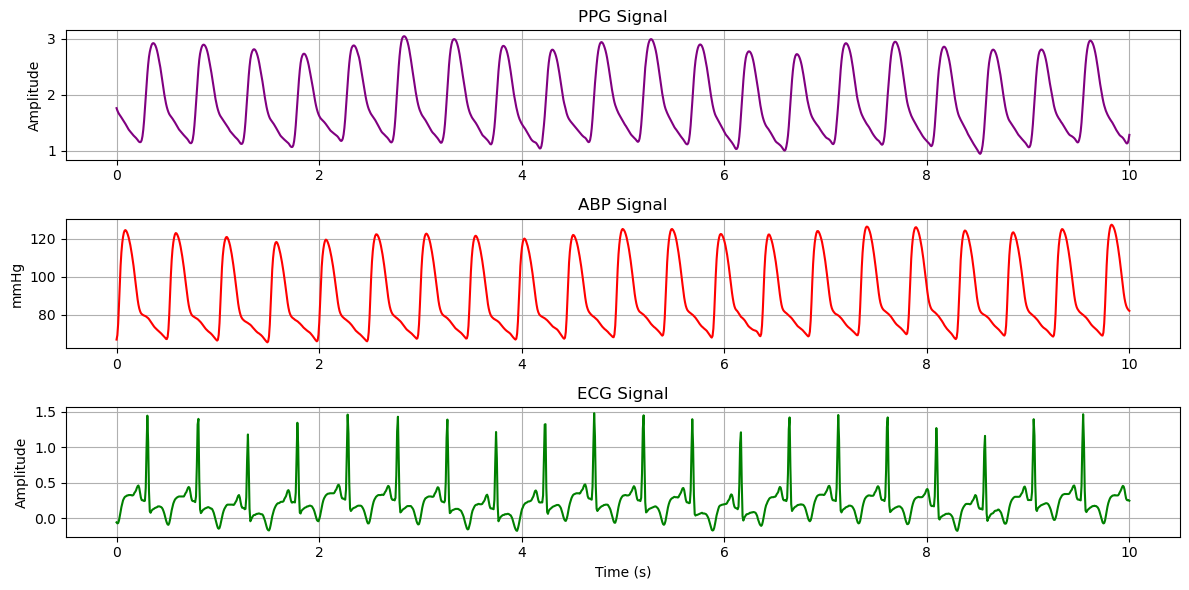

In [7]:
def plot_signals(signals, fs=125, duration=10):
    ppg, abp, ecg = signals
    length = min(len(ppg), len(abp), len(ecg), fs * duration)
    time = np.linspace(0, length / fs, length)

    plt.figure(figsize=(12, 6))

    plt.subplot(3, 1, 1)
    plt.plot(time, ppg[:length], color='purple')
    plt.title("PPG Signal")
    plt.ylabel("Amplitude")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time, abp[:length], color='red')
    plt.title("ABP Signal")
    plt.ylabel("mmHg")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time, ecg[:length], color='green')
    plt.title("ECG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example: visualize the first record
plot_signals(signals_list[0])


In [20]:
# Saving my model 
import joblib
joblib.dump(model, 'grb_modelV1.pkl')

['grb_modelV1.pkl']